*Eduardus Tjitrahardja | @edutjie | 2022*

# Data Sprint 85 - Water Potability Prediction

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

%matplotlib inline
plt.style.use("seaborn")

SEED = 2022

## Loading Dataset

In [3]:
train_df = pd.read_csv("data/train_dataset.csv")

train_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,219.674262,22210.613083,5.875041,333.775777,398.517703,11.502316,112.412210,2.994259,0
1,6.783888,193.653581,13677.106441,5.171454,323.728663,477.854687,15.056064,66.396293,3.250022,0
2,6.010618,184.558582,15940.573271,8.165222,421.486089,314.529813,20.314617,83.707938,4.867287,1
3,8.097454,218.992436,18112.284447,6.196947,333.775777,376.569803,17.746264,59.909941,4.279082,1
4,8.072612,210.269780,16843.363927,8.793459,359.516169,559.167574,17.263576,68.738989,5.082206,0


In [27]:
print("Train Dataset Shape:", train_df.shape)
train_df.info()

Train Dataset Shape: (2293, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2293 non-null   float64
 1   Hardness         2293 non-null   float64
 2   Solids           2293 non-null   float64
 3   Chloramines      2293 non-null   float64
 4   Sulfate          2293 non-null   float64
 5   Conductivity     2293 non-null   float64
 6   Organic_carbon   2293 non-null   float64
 7   Trihalomethanes  2293 non-null   float64
 8   Turbidity        2293 non-null   float64
 9   Potability       2293 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 179.3 KB


In [28]:
train_df.isnull().any()

ph                 False
Hardness           False
Solids             False
Chloramines        False
Sulfate            False
Conductivity       False
Organic_carbon     False
Trihalomethanes    False
Turbidity          False
Potability         False
dtype: bool

In [29]:
train_df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000
mean,7.082265,196.390335,22074.335334,7.132987,333.393347,425.455702,14.229174,66.499518,3.967153,0.390318
std,1.486029,32.460633,8668.693908,1.573879,36.116271,80.266652,3.341429,16.067742,0.788480,0.487928
min,0.000000,47.432000,320.942611,0.530351,180.206746,201.619737,2.200000,0.738000,1.450000,0.000000
25%,6.262799,176.753500,15825.182571,6.140033,316.552791,363.974060,12.015868,56.329076,3.440753,0.000000
50%,7.080795,196.833001,21153.322827,7.135063,333.775777,420.828362,14.151538,66.396293,3.947138,0.000000
75%,7.873272,216.441172,27345.174288,8.104498,349.985243,480.715208,16.450990,77.182622,4.503661,1.000000
max,14.000000,317.338124,56351.396304,13.043806,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


## EDA

### Visualizing the distribution of the target

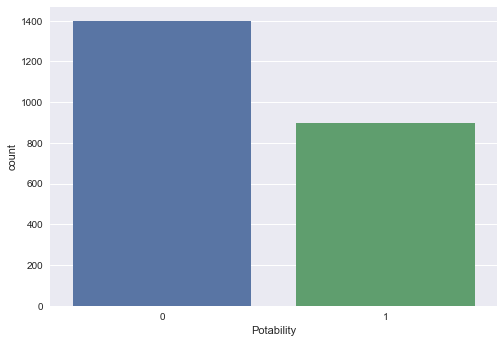

In [31]:
sns.countplot(x="Potability", data=train_df)
plt.show()

In [4]:
num_cols = train_df.columns.to_list()
num_cols.remove("Potability")
print(num_cols)

['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']


### Checking Outliers

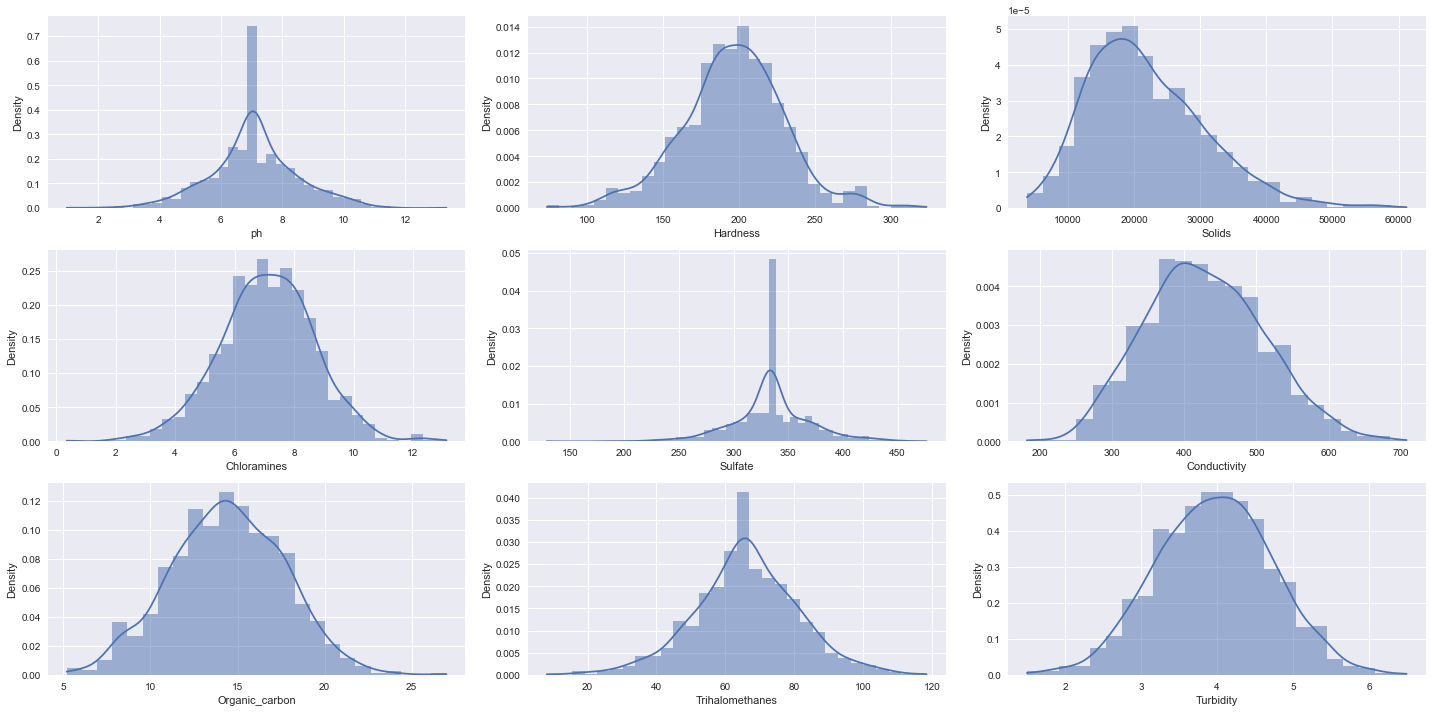

In [25]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))

for i, col in enumerate(num_cols):
    sns.histplot(train_df[col], ax=axes[i // 3, i % 3], kde=True, stat="density", linewidth=0)
plt.tight_layout()
plt.show()


#### Detecting Outlier using Z-score

In [5]:
train_dfz = train_df[num_cols].copy().add_prefix("z_")
train_dfz = train_dfz.apply(lambda x: (x - x.mean()) / x.std())
train_dfz.head()

,z_ph,z_Hardness,z_Solids,z_Chloramines,z_Sulfate,z_Conductivity,z_Organic_carbon,z_Trihalomethanes,z_Turbidity
0,-0.000990,0.717297,0.015721,-0.799265,0.010589,-0.335606,-0.816075,2.857445,-1.233885
1,-0.200788,-0.084310,-0.968684,-1.246305,-0.267599,0.652811,0.247466,-0.006424,-0.909511
2,-0.721149,-0.364495,-0.707576,0.655854,2.439143,-1.381967,1.821210,1.070992,1.141607
3,0.683156,0.696293,-0.457053,-0.594734,0.010589,-0.609044,1.052570,-0.410112,0.395608
4,0.666439,0.427578,-0.603432,1.055018,0.723298,1.665846,0.908115,0.139377,1.414180


In [6]:
outliers_index = []

for col in num_cols:
    outliers_index.extend(train_dfz[np.abs(train_dfz["z_" + col]) > 3].index.to_list())
    
outliers_index = list(set(outliers_index))
print(outliers_index)

[1541, 6, 1033, 2058, 2074, 28, 30, 1569, 546, 1571, 545, 1573, 38, 40, 2100, 1588, 2101, 1599, 578, 2117, 77, 1614, 595, 1623, 90, 2142, 2146, 1636, 2159, 114, 1138, 1652, 116, 122, 1666, 2186, 2187, 2193, 660, 2206, 161, 1698, 1193, 1711, 2224, 1207, 2233, 706, 197, 2258, 1240, 730, 736, 236, 750, 239, 1265, 766, 262, 1292, 1820, 298, 1324, 1328, 1330, 1843, 1338, 1339, 1854, 319, 831, 1858, 1870, 847, 1363, 1876, 854, 1882, 1373, 863, 355, 1389, 1926, 903, 394, 927, 1954, 1445, 425, 1467, 1470, 1472, 461, 471, 1532, 2045]


#### Drop Outliers

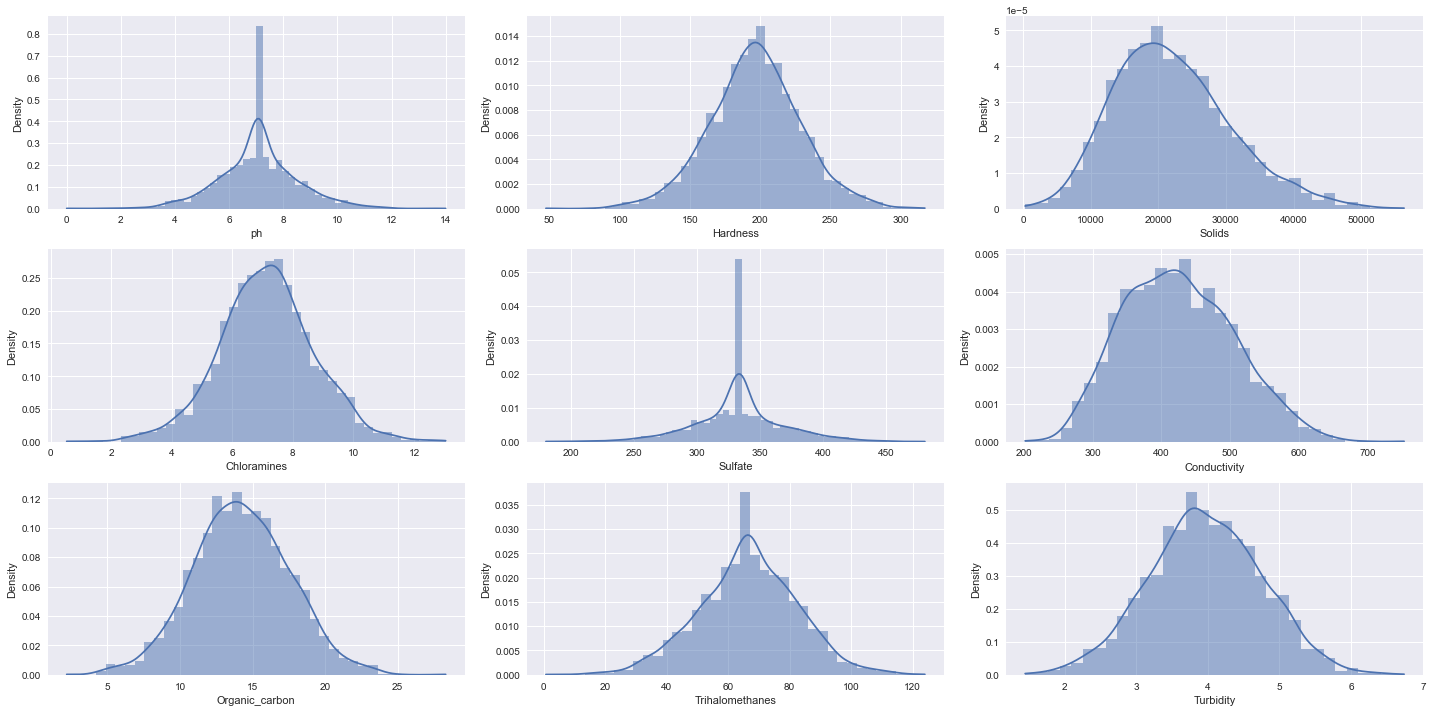

In [7]:
train_dfz.drop(outliers_index, inplace=True)

fig, axes = plt.subplots(3, 3, figsize=(20, 10))

for i, col in enumerate(num_cols):
    sns.histplot(train_df[col], ax=axes[i // 3, i % 3], kde=True, stat="density", linewidth=0)
plt.tight_layout()
plt.show()

In [57]:
print("After Droping Outliers:", train_dfz.shape)

After Droping Outliers: (2197, 9)


### Visualizing Correlation

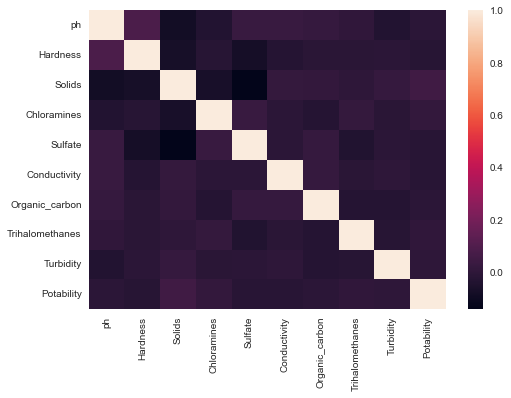

In [59]:
sns.heatmap(train_df.corr())
plt.show()

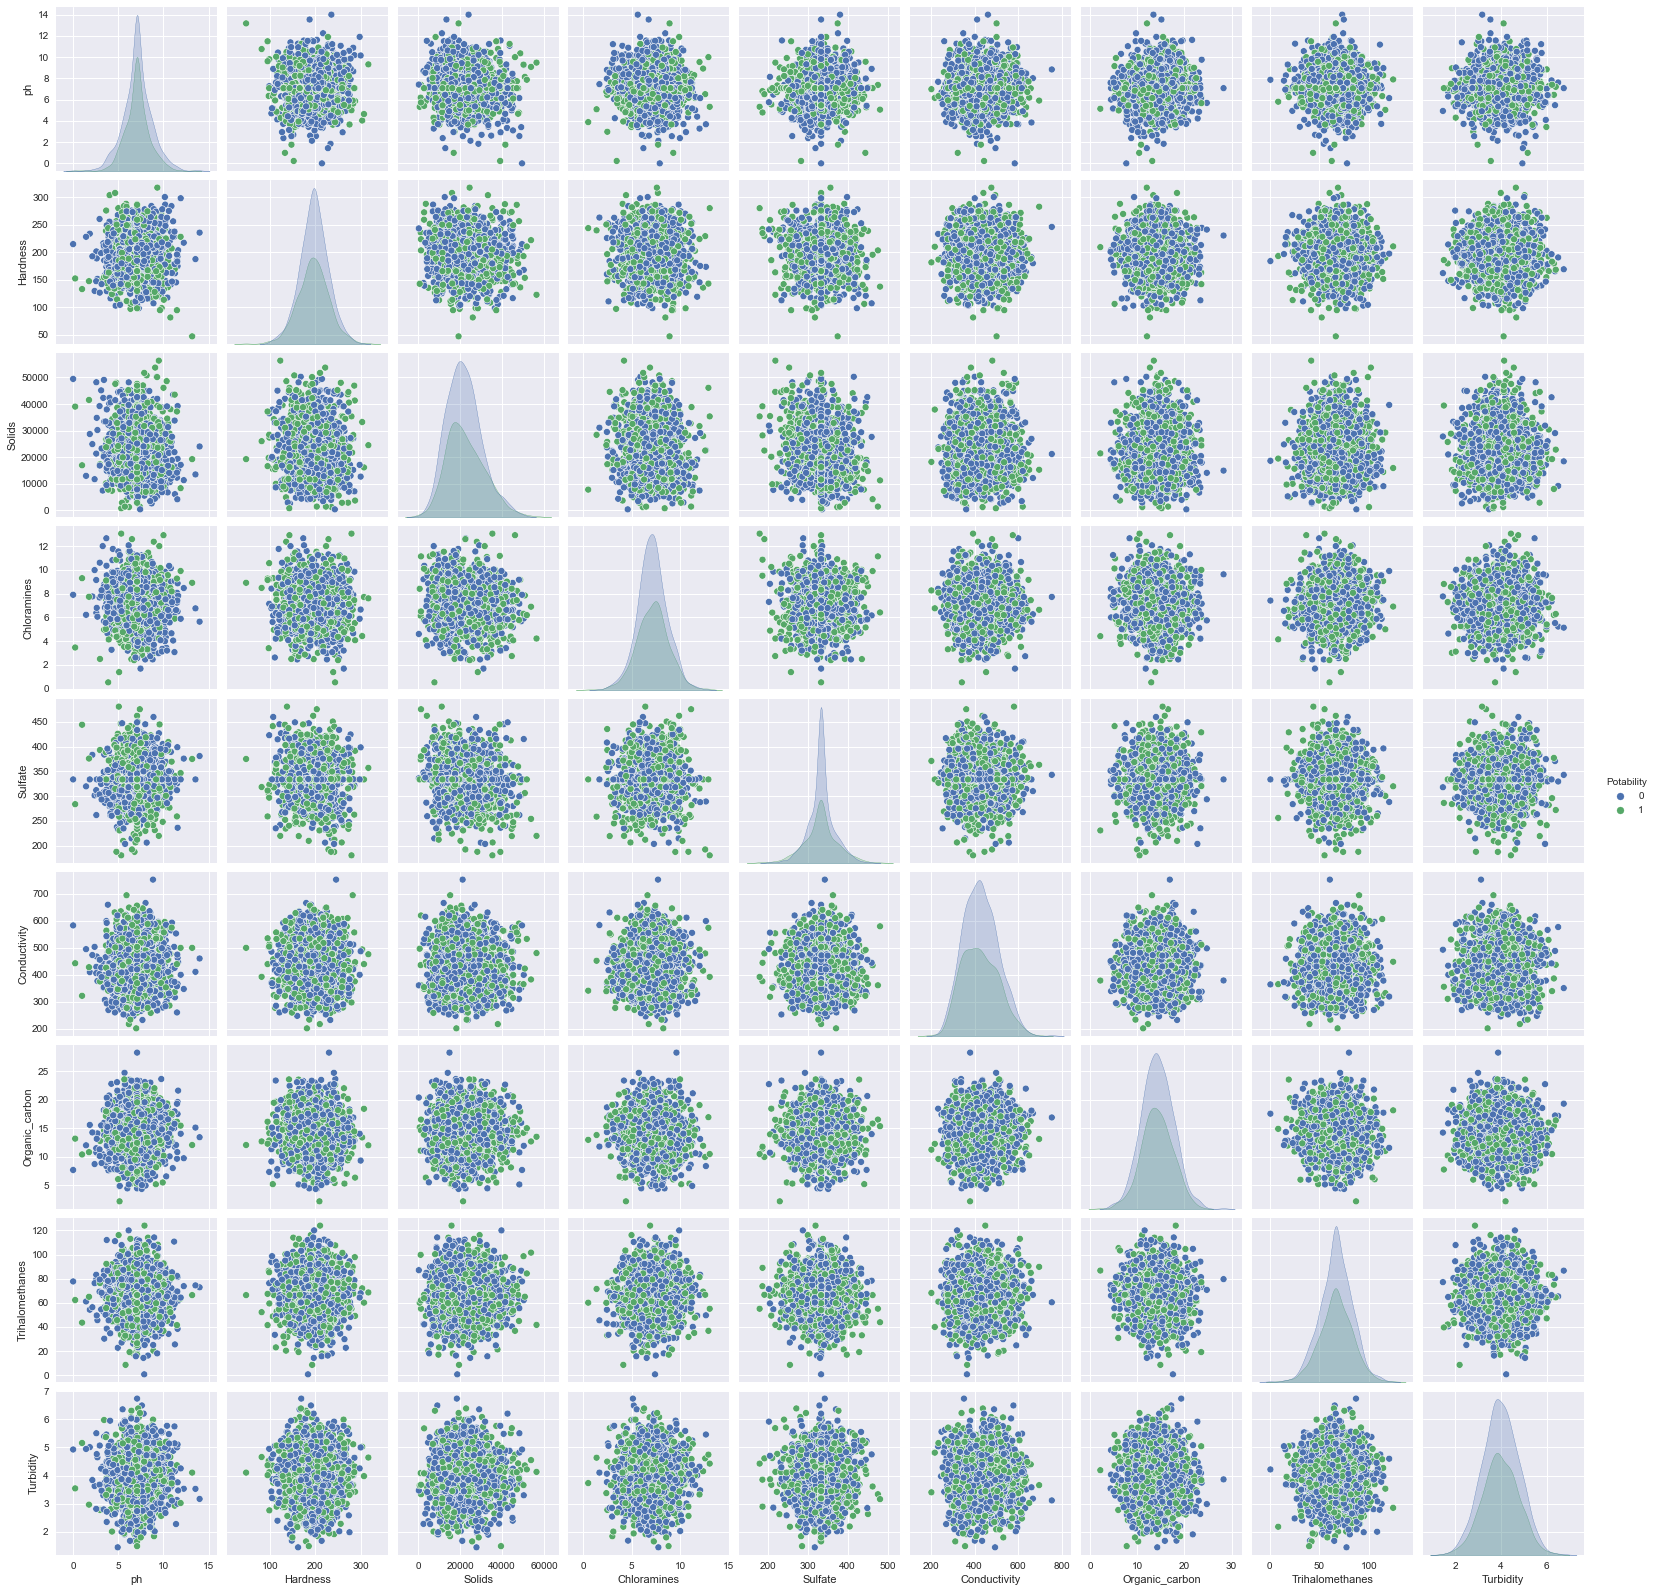

In [69]:
sns.pairplot(train_df, hue="Potability")
plt.show()

## Preparing Data for Training

In [8]:
X = train_df.drop("Potability", axis=1)
y = train_df.Potability

print("X Shape:", X.shape)
print("y Shape:", y.shape)

X Shape: (2293, 9)
y Shape: (2293,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (1834, 9)
X_test Shape: (459, 9)
y_train Shape: (1834,)
y_test Shape: (459,)


## Defining Model

In [10]:
def score_model(X, y, model):
    pred = model.predict(X)
    
    print(f"Pipeline Score: {model.score(X, y)}\n")
    print(f"Accuracy: {accuracy_score(y, pred)}\n")

    print(f"Confusion Matrix:")
    sns.heatmap(confusion_matrix(y, pred), annot=True, fmt="d", cmap="Blues")
    plt.show()

    print(f"Classification Report: \n{classification_report(y, pred)}\n")

    # kfold validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    kf_scores = cross_val_score(
        model, X, y, cv=kf, n_jobs=None, scoring="accuracy"
    )
    print(f"K-Fold test: {kf_scores}")
    print(f"K-Fold Mean: {kf_scores.mean()}")

In [11]:
lr_pipe = Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(random_state=SEED))])
rf_pipe = Pipeline([("scaler", StandardScaler()), ("rf", RandomForestClassifier(random_state=SEED))])
svc_pipe = Pipeline([("scaler", StandardScaler()), ("svc", SVC(random_state=SEED, probability=True))])
xgb_pipe = Pipeline([("scaler", StandardScaler()), ("xgb", XGBClassifier(random_state=SEED))])
cat_pipe = Pipeline([("scaler", StandardScaler()), ("cat", CatBoostClassifier(random_state=SEED))])

pipelines = [lr_pipe, rf_pipe, svc_pipe, xgb_pipe, cat_pipe]

LR
Pipeline Score: 0.5664488017429193

Accuracy: 0.5664488017429193

Confusion Matrix:


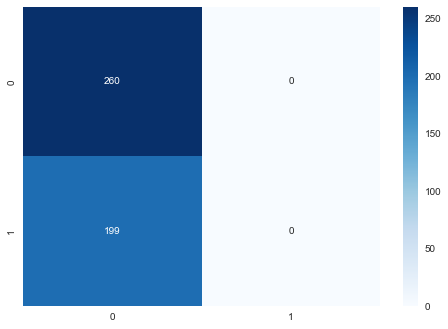

Classification Report: 
              precision    recall  f1-score   support

           0       0.57      1.00      0.72       260
           1       0.00      0.00      0.00       199

    accuracy                           0.57       459
   macro avg       0.28      0.50      0.36       459
weighted avg       0.32      0.57      0.41       459


K-Fold test: [0.55434783 0.5326087  0.54347826 0.5326087  0.57142857]
K-Fold Mean: 0.5468944099378883

RF


d:\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pipeline Score: 0.6514161220043573

Accuracy: 0.6514161220043573

Confusion Matrix:


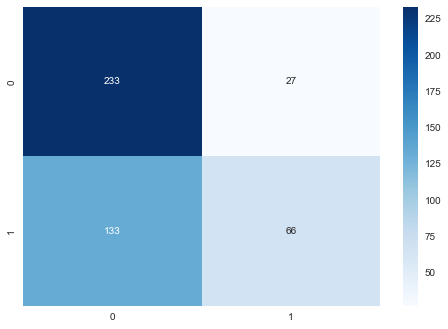

Classification Report: 
              precision    recall  f1-score   support

           0       0.64      0.90      0.74       260
           1       0.71      0.33      0.45       199

    accuracy                           0.65       459
   macro avg       0.67      0.61      0.60       459
weighted avg       0.67      0.65      0.62       459


K-Fold test: [0.63043478 0.70652174 0.61956522 0.67391304 0.61538462]
K-Fold Mean: 0.6491638795986622

SVC
Pipeline Score: 0.6492374727668845

Accuracy: 0.6492374727668845

Confusion Matrix:


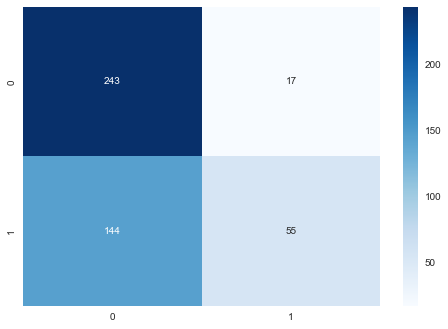

Classification Report: 
              precision    recall  f1-score   support

           0       0.63      0.93      0.75       260
           1       0.76      0.28      0.41       199

    accuracy                           0.65       459
   macro avg       0.70      0.61      0.58       459
weighted avg       0.69      0.65      0.60       459


K-Fold test: [0.60869565 0.61956522 0.58695652 0.61956522 0.65934066]
K-Fold Mean: 0.6188246536072622

XGB
Pipeline Score: 0.6296296296296297

Accuracy: 0.6296296296296297

Confusion Matrix:


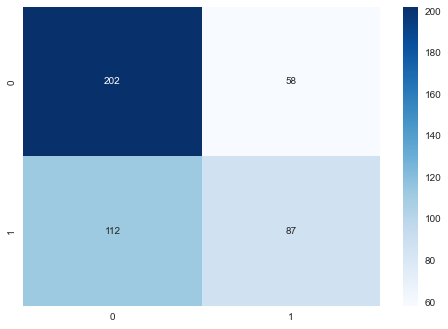

Classification Report: 
              precision    recall  f1-score   support

           0       0.64      0.78      0.70       260
           1       0.60      0.44      0.51       199

    accuracy                           0.63       459
   macro avg       0.62      0.61      0.60       459
weighted avg       0.62      0.63      0.62       459


K-Fold test: [0.63043478 0.66304348 0.65217391 0.63043478 0.64835165]
K-Fold Mean: 0.6448877209746775

CAT
Learning rate set to 0.013348
0:	learn: 0.6914525	total: 183ms	remaining: 3m 2s
1:	learn: 0.6901619	total: 185ms	remaining: 1m 32s
2:	learn: 0.6887411	total: 186ms	remaining: 1m 1s
3:	learn: 0.6871901	total: 188ms	remaining: 46.8s
4:	learn: 0.6859504	total: 189ms	remaining: 37.7s
5:	learn: 0.6842093	total: 191ms	remaining: 31.6s
6:	learn: 0.6828082	total: 192ms	remaining: 27.3s
7:	learn: 0.6817204	total: 194ms	remaining: 24.1s
8:	learn: 0.6803379	total: 195ms	remaining: 21.5s
9:	learn: 0.6787445	total: 197ms	remaining: 19.5s
10:	learn:

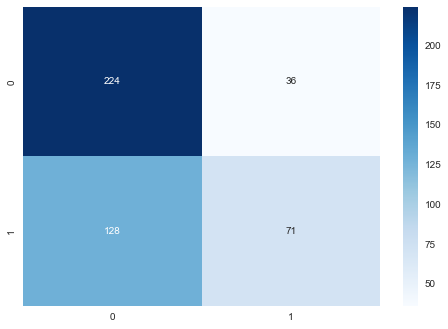

Classification Report: 
              precision    recall  f1-score   support

           0       0.64      0.86      0.73       260
           1       0.66      0.36      0.46       199

    accuracy                           0.64       459
   macro avg       0.65      0.61      0.60       459
weighted avg       0.65      0.64      0.62       459


Learning rate set to 0.006715
0:	learn: 0.6916635	total: 28.4ms	remaining: 28.4s
1:	learn: 0.6901768	total: 29.8ms	remaining: 14.9s
2:	learn: 0.6888152	total: 31.2ms	remaining: 10.4s
3:	learn: 0.6872001	total: 32.1ms	remaining: 7.99s
4:	learn: 0.6858404	total: 33.3ms	remaining: 6.63s
5:	learn: 0.6845211	total: 34.2ms	remaining: 5.67s
6:	learn: 0.6832315	total: 35.3ms	remaining: 5.01s
7:	learn: 0.6820414	total: 36.3ms	remaining: 4.51s
8:	learn: 0.6804774	total: 37.3ms	remaining: 4.11s
9:	learn: 0.6790950	total: 38.3ms	remaining: 3.79s
10:	learn: 0.6778644	total: 39.3ms	remaining: 3.53s
11:	learn: 0.6765301	total: 40.6ms	remaining: 3.34s
12:	

In [12]:
for pipe in pipelines:
    print(pipe.steps[1][0].upper())
    pipe.fit(X_train, y_train)
    score_model(X_test, y_test, pipe)
    print()

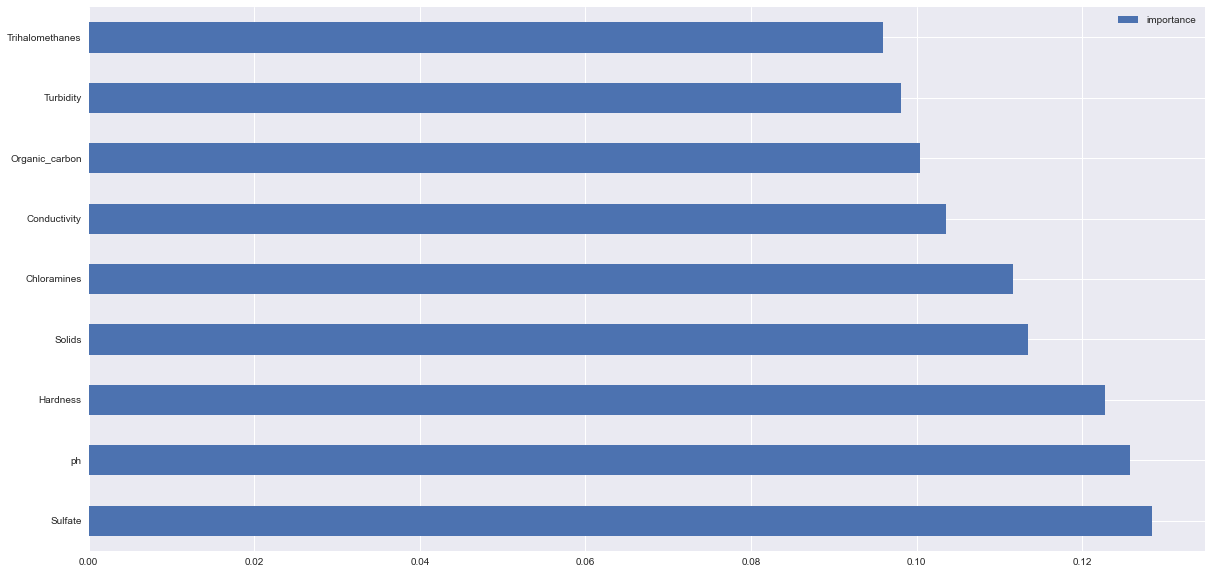

In [100]:
rf_feature_importances = pd.DataFrame(rf_pipe.steps[1][1].feature_importances_, index=X.columns, columns=['importance'])
rf_feature_importances.sort_values(by='importance', ascending=False).plot(kind='barh', figsize=(20, 10))
plt.show()

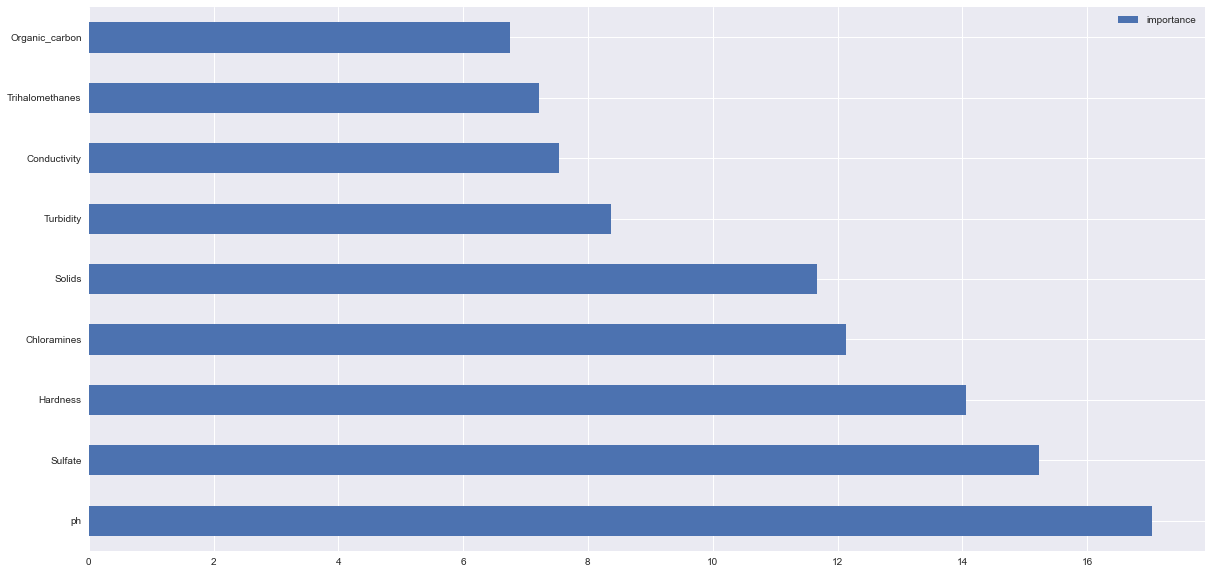

In [99]:
cb_feature_importances = pd.DataFrame(cat_pipe.steps[1][1].feature_importances_, index=X.columns, columns=['importance'])
cb_feature_importances.sort_values(by='importance', ascending=False).plot(kind='barh', figsize=(20, 10))
plt.show()

### SVC

In [106]:
params = {
    "svc__C": [0.1, 1, 10, 100],
    "svc__gamma": [1, 0.1, 0.01, 0.001],
    "svc__kernel": ["rbf", "poly", "linear"],
}

pipe = Pipeline([("scaler", StandardScaler()), ("svc", SVC(random_state=SEED, probability=True))])

grid = GridSearchCV(pipe, param_grid=params, n_jobs=-1, scoring="accuracy", cv=5)

In [107]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=2022))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10, 100],
                         'svc__gamma': [1, 0.1, 0.01, 0.001],
                         'svc__kernel': ['rbf', 'poly', 'linear']},
             scoring='accuracy')

In [109]:

print("Best Hyperparameters:", grid.best_params_)
print("Best f1 Score:", grid.best_score_)

Best Hyperparameters: {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best f1 Score: 0.6761081580083679


In [111]:
model = grid.best_estimator_

In [113]:
pickle.dump(model, open("checkpoints/model1.pkl", 'wb'))

In [25]:
 # load the model from disk
model = pickle.load(open("checkpoints/model1.pkl", 'rb'))

### CatBoost (Worse than SVC)

In [20]:
cat_params = {
    "cat__depth": [4, 5, 6, 7, 8, 9, 10],
    "cat__learning_rate": [0.01, 0.02, 0.03, 0.04],
    "cat__iterations": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
}

cat_grid = GridSearchCV(cat_pipe, param_grid=cat_params, n_jobs=-1, scoring="accuracy", cv=5)

In [21]:
cat_grid.fit(X_train, y_train)

0:	learn: 0.6892789	total: 2.6ms	remaining: 257ms
1:	learn: 0.6856774	total: 5.11ms	remaining: 250ms
2:	learn: 0.6827357	total: 6.84ms	remaining: 221ms
3:	learn: 0.6798281	total: 8.65ms	remaining: 208ms
4:	learn: 0.6768905	total: 10.5ms	remaining: 199ms
5:	learn: 0.6736558	total: 12.1ms	remaining: 190ms
6:	learn: 0.6708985	total: 13.8ms	remaining: 184ms
7:	learn: 0.6688082	total: 15.7ms	remaining: 181ms
8:	learn: 0.6656694	total: 17.5ms	remaining: 177ms
9:	learn: 0.6635089	total: 19.4ms	remaining: 174ms
10:	learn: 0.6617298	total: 21.1ms	remaining: 170ms
11:	learn: 0.6590785	total: 22.7ms	remaining: 167ms
12:	learn: 0.6565048	total: 24.5ms	remaining: 164ms
13:	learn: 0.6542899	total: 26.1ms	remaining: 161ms
14:	learn: 0.6517575	total: 27.8ms	remaining: 158ms
15:	learn: 0.6491483	total: 29.5ms	remaining: 155ms
16:	learn: 0.6468540	total: 31.5ms	remaining: 154ms
17:	learn: 0.6456855	total: 33.3ms	remaining: 152ms
18:	learn: 0.6439284	total: 35ms	remaining: 149ms
19:	learn: 0.6422146	tota

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('cat',
                                        <catboost.core.CatBoostClassifier object at 0x000002ACC4C70D60>)]),
             n_jobs=-1,
             param_grid={'cat__depth': [4, 5, 6, 7, 8, 9, 10],
                         'cat__iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                             100],
                         'cat__learning_rate': [0.01, 0.02, 0.03, 0.04]},
             scoring='accuracy')

In [24]:
print("Best Hyperparameters:", cat_grid.best_params_)
print("Best f1 Score:", cat_grid.best_score_)

Best Hyperparameters: {'cat__depth': 7, 'cat__iterations': 100, 'cat__learning_rate': 0.04}
Best f1 Score: 0.6723008889087417


In [16]:
# model = cat_grid.best_estimator_

## Submission

In [26]:
test_df = pd.read_csv("data/test_dataset.csv")
test_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,8.813505,236.392817,40684.390014,6.608775,303.529818,278.355123,14.576057,72.872697,4.242460
1,8.466013,224.174936,22523.124552,6.668868,286.943922,330.044715,17.744096,77.817804,3.946621
2,6.350290,190.383738,14905.393852,5.537830,333.775777,446.840605,13.983567,67.817096,4.265233
3,9.578227,205.748742,33080.588825,5.659848,356.698301,333.069911,16.984961,68.906088,3.419239
4,7.300990,182.447697,29136.338677,8.253015,333.775777,307.433303,8.730149,49.895342,4.596347


In [27]:
pred = model.predict(test_df)
pred

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,

In [19]:
submission = pd.DataFrame(pred) #target is nothing but the final predictions of your model on input features of your new unseen test data
submission.columns = ["Potability"]
submission.to_csv("submissions/submission2.csv", index = False)